In [1144]:
# Topic - Evolution of the rotation curve (“observed” and mass-derived) and velocity sdispersion profile

In [1146]:
# importing neccesary libaries
# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile

# for contours
import scipy.optimize as so

In [1148]:
# identifying simulation snapshots
# From the previous seperation plots, we need - 4 Gyr, 6 Gyr and a snapshot after this close encounter
# eg. 4 Gyr --> 4000 = (SN * 10)/0.7 = 280
# Thus, we need snapshots numbers - 280, 420 and 600

def file_read(snapshot_number):
    # First we will extract the disk and the bulge particle of the corresponding snapshot number of the MW and M31
    # Add 000 to all snapshots
    ilbl = '000' + str(snapshot_number)
    # remove all but the last 3 digits
    ilbl = ilbl[-3:]
    # create filenames for both MW and M31
    MW_filename='%s_'%("MW") + ilbl + '.txt'
    M31_filename = '%s_'%("M31") + ilbl + '.txt'

    # Read data (assuming Read function is implemented elsewhere)
    MW_time, MW_total, MW_data = Read("./"+MW_filename)
    print(MW_time.value)
    M31_time, M31_total, M31_data = Read("./"+M31_filename)

    # Extract disk (ptype = 2) and bulge (ptype = 3) particles
    MW_index = np.where((MW_data['type'] == 2) | (MW_data['type'] == 3))
    M31_index = np.where((M31_data['type'] == 2) | (M31_data['type'] == 3))


    # Store mass, positions, velocities, and type
    MW_particles = {
        'type': MW_data['type'][MW_index],  # Keep the actual type (2 or 3)
        'm': MW_data['m'][MW_index],
        'x': MW_data['x'][MW_index],
        'y': MW_data['y'][MW_index],
        'z': MW_data['z'][MW_index],
        'vx': MW_data['vx'][MW_index],
        'vy': MW_data['vy'][MW_index],
        'vz': MW_data['vz'][MW_index]
    }

    M31_particles = {
        'type': M31_data['type'][M31_index],  # Keep the actual type (2 or 3)
        'm': M31_data['m'][M31_index],
        'x': M31_data['x'][M31_index],
        'y': M31_data['y'][M31_index],
        'z': M31_data['z'][M31_index],
        'vx': M31_data['vx'][M31_index],
        'vy': M31_data['vy'][M31_index],
        'vz': M31_data['vz'][M31_index]
    }

    # Concatenate MW and M31 data
    # This will be later on used to access the mass and velocities directly
    combined_particles = {key: np.concatenate((MW_particles[key], M31_particles[key])) for key in MW_particles}

    output_filename = f"MWM31_{ilbl}.txt"
    # Write data to file in the same format
    with open(output_filename, 'w') as f:
        # This is the header
        f.write(f"Time   {MW_time.value}\n")
        f.write(f"Total      {len(combined_particles['m'])}\n")
        f.write("mass in 1e10,  x, y, z, in kpc and vx, vy, vz in km/s\n")
        f.write("#type, m, x, y, z, vx, vy, vz\n")

        # Write particle data
        for i in range(len(combined_particles['m'])):
            f.write(f"{combined_particles['type'][i]:f}  {combined_particles['m'][i]:f}  {combined_particles['x'][i]:f}  "
                    f"{combined_particles['y'][i]:f}  {combined_particles['z'][i]:f}  "
                    f"{combined_particles['vx'][i]:f}  {combined_particles['vy'][i]:f}  "
                    f"{combined_particles['vz'][i]:f}\n")

    print(f"Saved data to {output_filename}")
    return output_filename, combined_particles

In [1151]:
output_filename, combined_particles = file_read(600)

8571.42855
Saved data to MWM31_600.txt


In [1152]:
def normalized_vectors(output_filename):
    """
    Compute the center of mass (RCOM) and velocity (VCOM) for the given snapshot file.
    Transform particle positions and velocities into the COM reference frame.

    Parameters:
    output_filename (str): Name of the file containing MW+M31 particle data.

    Returns:
    r (ndarray): Array of transformed positions relative to COM.
    v (ndarray): Array of transformed velocities relative to COM.
    """

    # Initialize CenterOfMass for disk particles (ptype = 2)
    COMD = CenterOfMass(output_filename, 2)

    # Compute COM of M31 using disk particles
    COMP = COMD.COM_P(0.1)
    COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])
 
    # Determine positions of disk particles relative to COM 
    xD = COMD.x - COMP[0].value 
    yD = COMD.y - COMP[1].value 
    zD = COMD.z - COMP[2].value 
    
    # total magnitude
    rtot = np.sqrt(xD**2 + yD**2 + zD**2)
    
    # Determine velocities of disk particles relatiev to COM motion
    vxD = COMD.vx - COMV[0].value 
    vyD = COMD.vy - COMV[1].value 
    vzD = COMD.vz - COMV[2].value 
    
    # total velocity 
    vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)
    
    # Arrays for r and v 
    r = np.array([xD,yD,zD]).T # transposed 
    v = np.array([vxD,vyD,vzD]).T
    return r, v

In [1153]:
# Get the r and v in the COM frame 
r, v = normalized_vectors(output_filename)

In [1154]:
def RotateFrame(posI, velI):
    """
    Rotates the reference frame so that the angular momentum vector is aligned with the z-axis.
    
    Parameters:
    posI (ndarray): Nx3 array of particle positions.
    velI (ndarray): Nx3 array of particle velocities.
    
    Returns:
    pos (ndarray): Rotated positions.
    vel (ndarray): Rotated velocities.
    """

    # Compute total angular momentum vector
    L = np.sum(np.cross(posI, velI), axis=0)

    # Normalize angular momentum vector
    L_norm = L / np.linalg.norm(L)

    # Define z-axis unit vector
    z_norm = np.array([0, 0, 1])

    # Compute cross and dot products
    vv = np.cross(L_norm, z_norm)
    s = np.linalg.norm(vv)  # Magnitude of cross product
    c = np.dot(L_norm, z_norm)

    # Handle edge case: If already aligned with z-axis, no rotation needed
    if np.isclose(s, 0):  
        return posI, velI  # No rotation required

    # Rotation matrix (Rodrigues' rotation formula)
    I = np.eye(3)
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x) * ((1 - c) / s**2)

    # Apply rotation
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T

    return pos, vel

In [1155]:
# Get the velocities and radius rotated
rn, vn = RotateFrame(r,v)

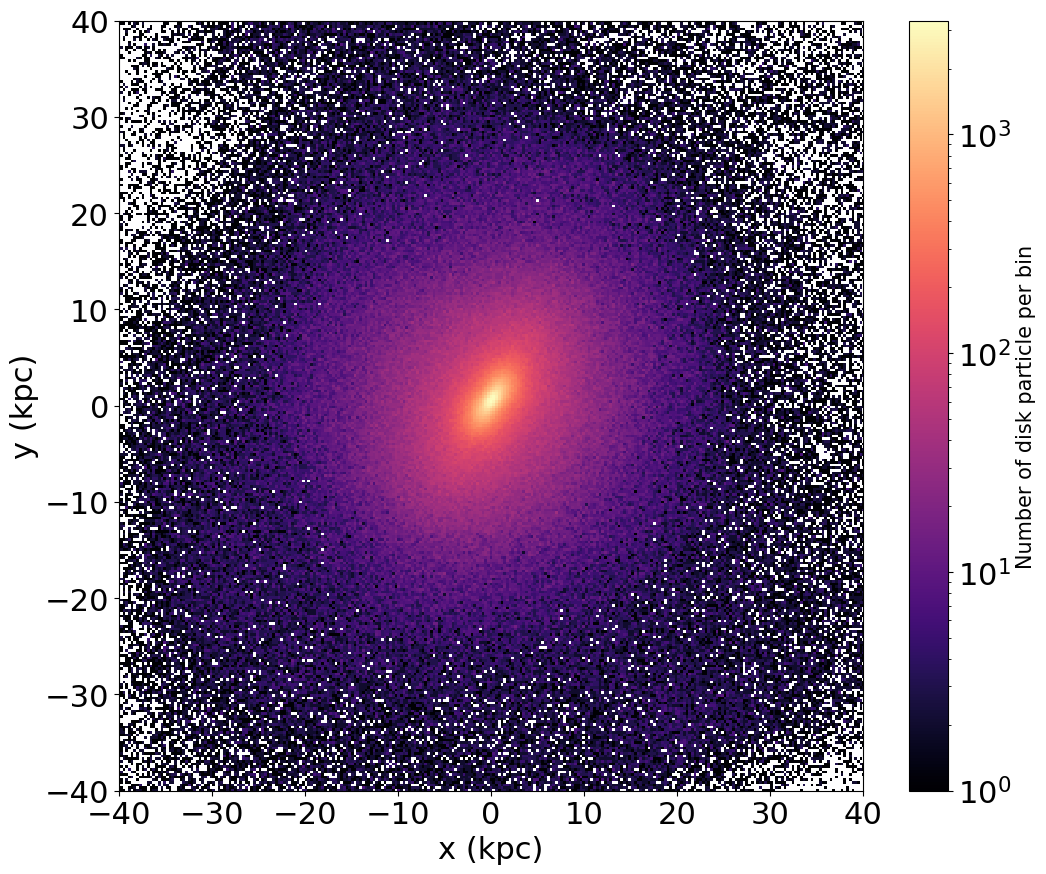

In [1156]:

# M31 Disk Density 
fig, ax= plt.subplots(figsize=(12, 10))

# plot the particle density for M31 
# Change the bin number if M31 is the high res version 
plt.hist2d(rn[:,0], rn[:,1], bins=2000, norm=LogNorm(), cmap='magma')
cbar = plt.colorbar()
cbar.set_label("Number of disk particle per bin", fontsize=15)


# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('y (kpc)', fontsize=22)

#set axis limits
plt.ylim(-40,40)
plt.xlim(-40,40)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


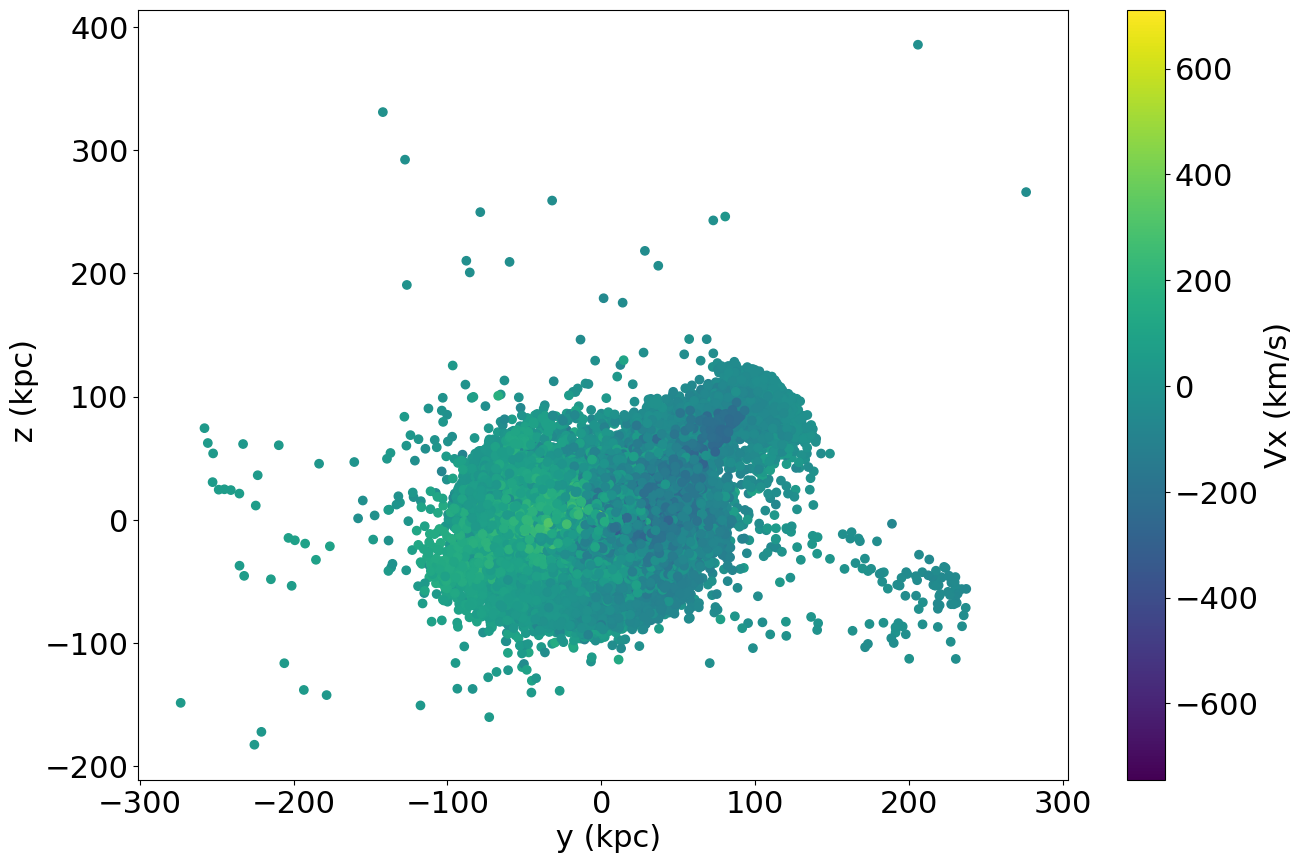

In [1157]:
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)

# plot position of disk particles color 
# coded by velocity along the 3rd axis
# plt.scatter(pos1, pos2, c=vel1)
# ADD HERE 
plt.scatter(rn[:,1], rn[:,2], c=vn[:,0])

#colorbar
cbar = plt.colorbar()
cbar.set_label('Vx (km/s)', size=22)

# Add axis labels
plt.xlabel(' y (kpc)', fontsize=22)
plt.ylabel(' z (kpc)', fontsize=22)



#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Save file
plt.savefig('Lab7_EdgeOn_Vel.png')

In [1158]:
# Get the mass profile for this merger remnant
MWM31 = MassProfile('MWM31', 600)

In [1159]:
# Get the range of radius to get the circular velocity
rr = np.arange(0.01, 45, 0.1)

In [1160]:
# Circular Velocity Profile
Vcirc = MWM31.circularVelocityTotal(rr)

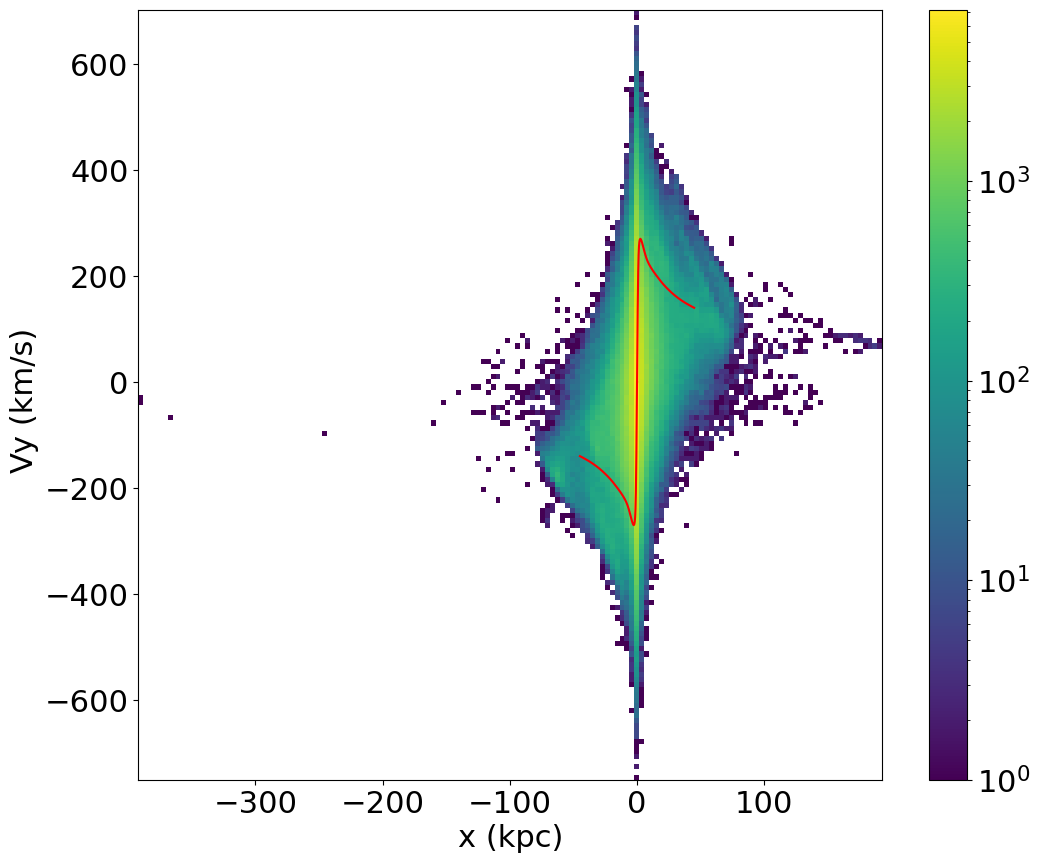

In [1162]:
fig = plt.figure(figsize=(12,10))
ax = plt.subplot(111)

# Plot 2D Histogram for one component of  Pos vs Vel 
plt.hist2d(rn[:,0], vn[:,1], bins=150, norm=LogNorm())
plt.colorbar()

# Overplot Circular Velocity from the MassProfile Code
plt.plot(rr,Vcirc, color='red')
plt.plot(-rr, -Vcirc, color='red')

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('Vy (km/s) ', fontsize=22)



#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size



# Save file
#plt.savefig('Lab7_RotationCurve.png')

In [1163]:
def compute_half_mass_radius(masses, radii):
    """
    Compute the half-mass radius given particle masses and radii.

    Parameters
    ----------
    masses : numpy array
        Array of particle masses.
    radii : numpy array
        Array of corresponding particle radii.

    Output
    ------
    half_mass_radius : float
        The radius within which half of the total mass is enclosed.
    """
    # Sort indices based on radii
    sorted_indices = np.argsort(radii)
    sorted_masses = masses[sorted_indices]
    sorted_radii = radii[sorted_indices]
    
    # Compute cumulative mass
    cumulative_mass = np.cumsum(sorted_masses)
    half_mass = np.sum(masses) / 2
    
    # Find the radius where half the mass is enclosed
    half_mass_radius = sorted_radii[np.searchsorted(cumulative_mass, half_mass)]
    return half_mass_radius

In [1164]:
def compute_velocity_dispersion(vx, vy, vz):
    """
    Compute the velocity dispersion sigma, a measure of velocity spread.

    Parameters
    ----------
    vx : numpy array
        Array of velocity components along x-axis.
    vy : numpy array
        Array of velocity components along y-axis.
    vz : numpy array
        Array of velocity components along z-axis.

    Output
    ------
    sigma : float
        The velocity dispersion computed from the variances of velocity components.
    """
    # Compute velocity dispersion using the sum of variances of velocity components
    sigma = np.sqrt(np.var(vx) + np.var(vy) + np.var(vz))
    return sigma

In [1165]:
# velocity in cylindrical coordinates. 

# radius 
rho = np.sqrt(rn[:,0]**2 + rn[:,1]**2) 

# radial velocity 
vr = (rn[:,0] * vn[:,0] + rn[:,1] * vn[:,1]) / rho

# azimuthal velocity
vphi = (rn[:,0] *  vn[:,1] - rn[:,1] * vn[:,0]) / rho

In [1167]:
# Determine the mean vphi per radius

# Initialize Array for Radius 0-40 kpc
r2 = np.arange(0,41,1)

# Initialize Empty Array for Velocity 
# (same size as radial array)
v2= np.zeros(np.size(r2))
#print(v2)
#print(r2)

In [1168]:
# compute the mean vphi in radial bins

for i in r2:
    index = np.where((rho > i) & (rho < i+1)) # walking out in radial bins
    v2[i] = np.mean(np.abs(vphi[index])) # mean velocity

# print(v2)

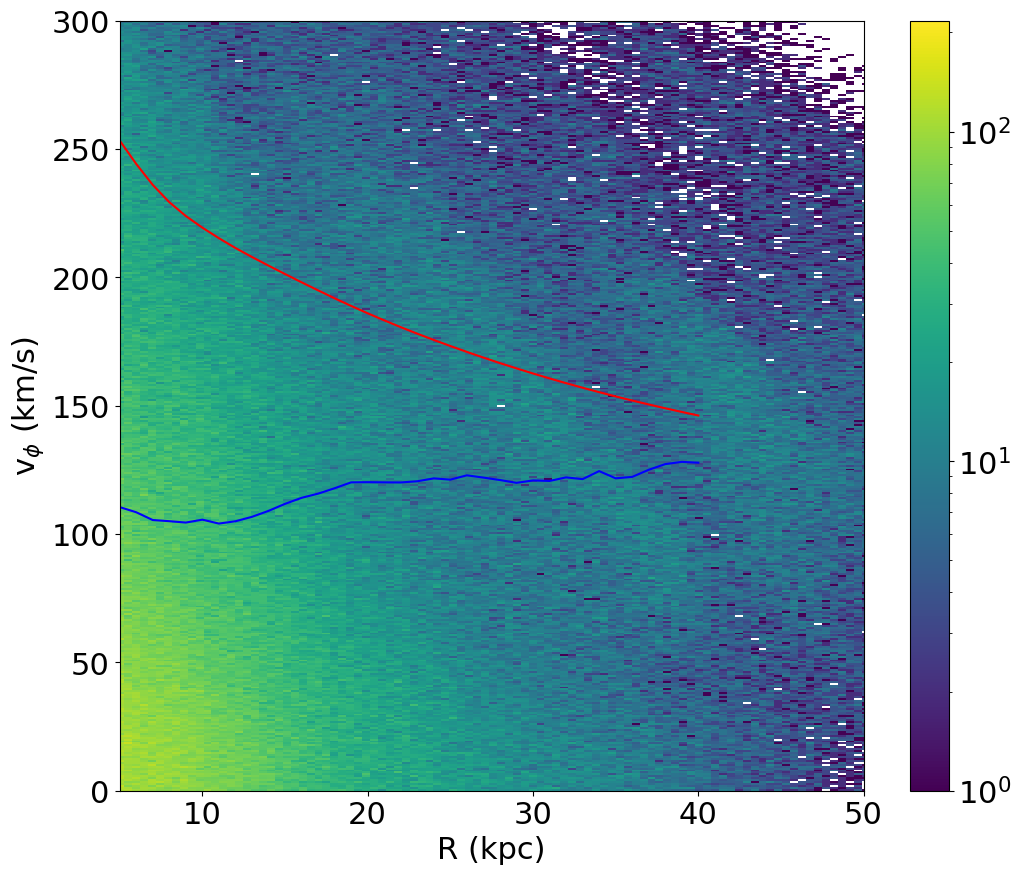

In [1169]:
# Make a phase diagram
# MW Disk Velocity Field edge on.
Vcirc = MWM31.circularVelocityTotal(r2)

fig = plt.figure(figsize=(12,10))
ax = plt.subplot(111)

# looking at MW edge on along x axis, vy is line of sight velocity

plt.hist2d(rho, np.abs(vphi), bins=1000, norm=LogNorm())
#plt.scatter(rho, np.abs(vphi))
plt.colorbar()

# Add the circular velocity
plt.plot(r2, Vcirc, color="red")
#plt.plot(-r, -Vcirc, color="red")


# Add the circular velocity
plt.plot(r2, v2, color="blue")
#plt.plot(-r2, -v2, color="blue")


# Add axis labels
plt.xlabel('R (kpc)', fontsize=22)
plt.ylabel(r'v$_\phi$ (km/s)', fontsize=22)

#set axis limits
plt.ylim(0, 300)
plt.xlim(5, 50)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

#plt.savefig('Vphi_r_600.png')


In [1170]:
rn.shape
rn[0]

array([-14.25031678,  -9.40038488,  18.70556064])

In [1171]:
mask = combined_particles['type'] == 2
print(mask)

[ True  True  True ... False False False]


In [1172]:
masses = combined_particles['m'][mask]
masses

array([2.e-05, 2.e-05, 2.e-05, ..., 2.e-05, 2.e-05, 2.e-05])

In [1173]:
#masses = combined_particles['m']
# DO ONLY THE DISK PARTICLES
radii = np.linalg.norm(rn[:, :2], axis=1)  


In [1175]:
half_mass_radius = compute_half_mass_radius(masses, radii)
R_half = half_mass_radius
R_half

8.188099704573805

In [1176]:
within_Rhalf = rho <= R_half
vphi_within = vphi[within_Rhalf]
print(len(vphi_within))

487501


In [1179]:
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic

# Step 1: Bin vphi as a function of R
n_bins = 30
bin_stat, bin_edges, _ = binned_statistic(rho, vphi, statistic='mean', bins=n_bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Step 2: Interpolate mean vphi as function of R
vphi_interp = interp1d(bin_centers, bin_stat, kind='linear', fill_value='extrapolate')

# Step 3: Evaluate vphi at R_half
Vphi_at_Rhalf = vphi_interp(R_half)


In [1180]:
within_Rhalf = rho <= R_half
vphi_within = vphi[within_Rhalf]

sigma_phi = np.std(vphi_within)  # Or use weighted version if masses vary


In [1181]:
Vphi_over_sigma = Vphi_at_Rhalf / sigma_phi
print(f"Vphi(R_half) / sigma_phi (within R_half): {Vphi_over_sigma:.3f}")


Vphi(R_half) / sigma_phi (within R_half): 0.235


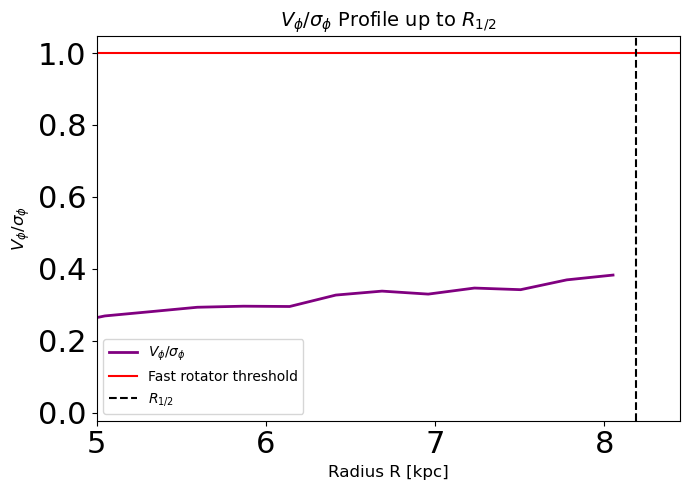

In [1214]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

# Parameters
n_bins = 30
R_max = R_half

# Filter data within R_half
within_Rhalf = rho <= R_max
rho_within = rho[within_Rhalf]
vphi_within = vphi[within_Rhalf]

# Define bins and centers
bin_edges = np.linspace(0, R_max, n_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Initialize arrays
vphi_mean = np.zeros(n_bins)
sigma_phi = np.zeros(n_bins)
V_over_sigma = np.zeros(n_bins)

# Compute mean and dispersion in each bin
for i in range(n_bins):
    mask = (rho_within >= bin_edges[i]) & (rho_within < bin_edges[i+1])
    if np.sum(mask) > 1:
        v_bin = vphi_within[mask]
        vphi_mean[i] = np.mean(v_bin)
        sigma_phi[i] = np.std(v_bin)
        V_over_sigma[i] = vphi_mean[i] / sigma_phi[i] if sigma_phi[i] != 0 else np.nan
    else:
        V_over_sigma[i] = np.nan

# Plot
plt.figure(figsize=(7, 5))
plt.plot(bin_centers, V_over_sigma, color='purple', lw=2, label=r'$V_\phi / \sigma_\phi$')
plt.axhline(1, color='red', linestyle='-', label='Fast rotator threshold')
plt.xlabel('Radius R [kpc]', fontsize=12)
plt.ylabel(r'$V_\phi / \sigma_\phi$', fontsize=12)
plt.title(r'$V_\phi / \sigma_\phi$ Profile up to $R_{1/2}$', fontsize=14)
plt.axvline(R_half, color='black', linestyle='--', label=r'$R_{1/2}$')
plt.xlim(left = 5)
plt.legend()
plt.tight_layout()
plt.savefig('600_V_Sigma1.png')
plt.show()
